In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/"My Drive"/"Data Colab"/ml-pg-project

/content/drive/My Drive/Data Colab/ml-pg-project


In [ ]:
import pandas as pd
import torch.utils.data as Data
import torch.nn as nn
import numpy as np
import torch
from sklearn.decomposition import PCA
from tqdm import tqdm

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
TOTAL_FEATURES = 6
DAYS = 60
BATCH_SIZE = 128

In [ ]:
class StockMarketDataReg(Data.Dataset):
    def __init__(self, train=None, split=0.2, target_market="S&P", days=60):
        self.days = days + 1 # as last entry is to be predicted

        df = pd.read_csv(f"Processed_{target_market}.csv")
        df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
        df = df.sort_values(by='Date')
        df = df.drop(columns=['Name', 'Date'])
        df = df.fillna(0)
        
        # outlier detection
        for col in df.columns:
            q1, q3 = df[col].quantile([0.25, 0.75])
            iqr = q3 - q1
            lb, rb = q1 - 1.5 * iqr, q3 + 1.5 * iqr
            for i in range(len(df)):
                if df[col][i] > rb:
                    df[col][i] = rb
                if df[col][i] < lb:
                    df[col][i] = lb

        self.feature_list = list(set(df.columns) - set(['Close']))
        if train is None:
            u = df.iloc[0: int(len(df) * (1 - split))]
            # pca
            self.pca = PCA(TOTAL_FEATURES - 1)
            self.pca_data = self.pca.fit_transform(u[self.feature_list])
            self.closing_prices = u['Close'].to_numpy()
            self.data = np.hstack(( self.closing_prices.reshape((-1, 1)), self.pca_data ))
        else:
            u = df.iloc[int(len(df) * (1 - split)) - self.days:]
            # pca
            self.pca_data = train.pca.transform(u[self.feature_list])
            self.closing_prices = u['Close'].to_numpy()
            self.data = np.hstack(( self.closing_prices.reshape((-1, 1)), self.pca_data ))

        self.num_rows = u.shape[0]
    
    def __getitem__(self, idx):
        end_idx = self.days + idx - 1
        market_tens = torch.from_numpy(self.data[idx: end_idx + 1])
        return market_tens.float()
    
    def __len__(self):
        return self.num_rows - self.days

In [ ]:
train_ds = StockMarketDataReg(target_market='S&P', split=0.2, days=DAYS)
test_ds = StockMarketDataReg(target_market='S&P', split=0.2, days=DAYS, train=train_ds)

In [ ]:
train_dataloader = Data.DataLoader(train_ds, batch_size=BATCH_SIZE)

In [ ]:
sample = next(iter(train_dataloader)).to(device)
sample.shape

torch.Size([128, 61, 6])

In [ ]:
class Generator(nn.Module):
    '''
    Generates fake data using features of past DAYS days
    '''
    def __init__(self, num_features, days, hidden_size=150):
        super().__init__()
        self.num_features = num_features
        self.days = days
        self.hidden_size = hidden_size
        # model
        self.lstm = nn.LSTM(input_size=self.num_features, hidden_size=self.hidden_size, num_layers=1, batch_first=True)
        self.decoder = nn.Sequential(
                nn.Linear(self.hidden_size * self.days, 2000),
                nn.BatchNorm1d(2000, momentum=0.9, eps=1e-05),
                nn.Tanh(),
                nn.Linear(2000, 500),
                nn.BatchNorm1d(500, momentum=0.9, eps=1e-05),
                nn.Tanh(),
                nn.Linear(500, 100),
                nn.ReLU(),
                nn.Linear(100, self.num_features),
                nn.ReLU()
            )
    def forward(self, inp):
        out1, _ = self.lstm(inp)
        out1 = out1.reshape((-1, self.hidden_size * self.days))
        out2 = self.decoder(out1)
        out2 = out2.squeeze()
        return out2

In [ ]:
class Discriminator(nn.Module):
    '''
    Discriminates between real data and fake data of DAYS + 1 days
    '''
    def __init__(self, num_features, c=5):
        # c denotes flatenning constant
        super().__init__()
        self.c = c
        self.num_features = num_features
        self.convs = nn.Sequential(
            nn.Conv1d(self.num_features, 32, kernel_size=5, stride=2),
            nn.LeakyReLU(0.01),
            nn.Conv1d(32, 64, kernel_size=5, stride=2),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(64, momentum=0.9, eps=1e-05), 
            nn.Conv1d(64, 128, kernel_size=5, stride=2),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(128, momentum=0.9, eps=1e-05),
        )
        self.dense = nn.Sequential(
            nn.Linear(128 * self.c, 220),
            nn.BatchNorm1d(220, momentum=0.9, eps=1e-05),
            nn.LeakyReLU(0.01),
            nn.Linear(220, 1),
            nn.Sigmoid()
        )
        self.linear = nn.Sequential(
            nn.Linear((DAYS + 1) * self.num_features, 200),
            nn.BatchNorm1d(200, momentum=0.9, eps=1e-05),
            nn.ReLU(), 
            nn.Linear(200, 50),
            nn.ReLU(),
            nn.Linear(50, 1),
            nn.Sigmoid()
        )
    def forward(self, inp):
        inp = torch.transpose(inp, 2, 1)
        out1 = self.convs(inp)
        out1 = out1.reshape(-1, 128 * self.c)
        out2 = self.dense(out1)
        out2 = out2.squeeze()
        return out2
        # inp = inp.view(-1, (DAYS + 1) * self.num_features)
        # return self.linear(inp).squeeze()

In [ ]:
criterion = torch.nn.BCELoss()

generator = Generator(TOTAL_FEATURES, DAYS)
generator = generator.to(device)

discriminator = Discriminator(TOTAL_FEATURES)
discriminator = discriminator.to(device)
    
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.002)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.002)

In [ ]:
NUM_EPOCHS = 50

In [ ]:
for epoch in range(NUM_EPOCHS):
    running_G_loss, running_D_loss = 0, 0
    correct, cnt = 0, 0
    for data in tqdm(train_dataloader):
        #### discriminator 
        discriminator.zero_grad()
        data = data.to(device)
        real_prev, real_now = data[:, :-1], data[:, -1]
        labels = torch.ones(len(data)).float().to(device)
        
        ## real
        # forward
        output = discriminator(data)
        # loss
        error_D_real = criterion(output, labels)
        error_D_real.backward()
        D_x = output.mean().item()

        ## fake
        labels.fill_(0)
        # forward on generator
        fake_now = generator(real_prev)
        fake = torch.hstack((real_prev, fake_now.unsqueeze(1)))
        # forward on discriminator
        output = discriminator(fake.detach())
        # loss
        error_D_fake = criterion(output, labels)
        error_D_fake.backward()
        D_G_z1 = output.mean().item()
        
        # step
        optimizer_D.step()

        #### generator
        labels.fill_(1)
        optimizer_G.zero_grad()
        # calculate discriminator output
        output = discriminator(fake)
        # loss
        error_G = criterion(output, labels)
        error_G.backward()
        D_G_z2 = output.mean().item()
        # step
        optimizer_G.step()
        
        error_D = error_D_real + error_D_fake
        running_D_loss += error_D.item()
        running_G_loss += error_G.item()
        real_up = real_now[:, 0] > real_prev[:, -1, 0]
        fake_up = fake_now[:, 0] > real_prev[:, -1, 0]
        correct += (real_up == fake_up).sum().item()
        cnt += len(data)

    correct /= cnt        
    print(f'epoch {epoch + 1}: g_loss={running_G_loss:.4f}, d_loss={running_D_loss:.4f}, accuracy={correct:.4f}')        
    print(f'D(x): {D_x:.3f}, D(G(z)): {D_G_z1:.3f} {D_G_z2:.3f}')
    print()

100%|██████████| 12/12 [00:00<00:00, 13.59it/s]


epoch 1: g_loss=9.4972, d_loss=17.6637, accuracy=0.4567
D(x): 0.489, D(G(z)): 0.487 0.492



100%|██████████| 12/12 [00:00<00:00, 15.93it/s]


epoch 2: g_loss=8.4515, d_loss=17.0833, accuracy=0.4567
D(x): 0.499, D(G(z)): 0.497 0.496



100%|██████████| 12/12 [00:00<00:00, 15.81it/s]


epoch 3: g_loss=8.4887, d_loss=16.8076, accuracy=0.4567
D(x): 0.502, D(G(z)): 0.500 0.501



100%|██████████| 12/12 [00:00<00:00, 15.88it/s]


epoch 4: g_loss=8.2601, d_loss=16.6734, accuracy=0.4567
D(x): 0.504, D(G(z)): 0.502 0.499



100%|██████████| 12/12 [00:00<00:00, 16.03it/s]


epoch 5: g_loss=8.4763, d_loss=16.5699, accuracy=0.4567
D(x): 0.506, D(G(z)): 0.501 0.503



100%|██████████| 12/12 [00:00<00:00, 16.05it/s]


epoch 6: g_loss=8.3465, d_loss=16.4901, accuracy=0.4567
D(x): 0.504, D(G(z)): 0.496 0.496



100%|██████████| 12/12 [00:00<00:00, 15.77it/s]


epoch 7: g_loss=8.4462, d_loss=16.3794, accuracy=0.4567
D(x): 0.513, D(G(z)): 0.499 0.498



100%|██████████| 12/12 [00:00<00:00, 16.15it/s]


epoch 8: g_loss=8.5281, d_loss=16.2501, accuracy=0.4567
D(x): 0.514, D(G(z)): 0.494 0.492



100%|██████████| 12/12 [00:00<00:00, 15.96it/s]


epoch 9: g_loss=8.7631, d_loss=16.0646, accuracy=0.4567
D(x): 0.529, D(G(z)): 0.500 0.497



100%|██████████| 12/12 [00:00<00:00, 15.91it/s]


epoch 10: g_loss=8.9752, d_loss=15.8825, accuracy=0.4567
D(x): 0.526, D(G(z)): 0.481 0.473



100%|██████████| 12/12 [00:00<00:00, 16.01it/s]


epoch 11: g_loss=9.1626, d_loss=15.6876, accuracy=0.4567
D(x): 0.532, D(G(z)): 0.488 0.480



100%|██████████| 12/12 [00:00<00:00, 15.70it/s]


epoch 12: g_loss=9.2030, d_loss=16.1747, accuracy=0.4600
D(x): 0.518, D(G(z)): 0.478 0.475



100%|██████████| 12/12 [00:00<00:00, 16.12it/s]


epoch 13: g_loss=9.0639, d_loss=15.8851, accuracy=0.4895
D(x): 0.547, D(G(z)): 0.515 0.501



100%|██████████| 12/12 [00:00<00:00, 16.12it/s]


epoch 14: g_loss=9.4879, d_loss=15.9183, accuracy=0.4869
D(x): 0.532, D(G(z)): 0.487 0.483



100%|██████████| 12/12 [00:00<00:00, 16.14it/s]


epoch 15: g_loss=9.4280, d_loss=15.8208, accuracy=0.5013
D(x): 0.519, D(G(z)): 0.473 0.460



100%|██████████| 12/12 [00:00<00:00, 16.11it/s]


epoch 16: g_loss=9.4730, d_loss=15.5650, accuracy=0.4764
D(x): 0.562, D(G(z)): 0.486 0.466



100%|██████████| 12/12 [00:00<00:00, 16.00it/s]


epoch 17: g_loss=10.5319, d_loss=14.6743, accuracy=0.4817
D(x): 0.567, D(G(z)): 0.448 0.437



100%|██████████| 12/12 [00:00<00:00, 16.00it/s]


epoch 18: g_loss=10.2896, d_loss=14.6508, accuracy=0.5026
D(x): 0.561, D(G(z)): 0.397 0.396



100%|██████████| 12/12 [00:00<00:00, 16.03it/s]


epoch 19: g_loss=10.8513, d_loss=14.0358, accuracy=0.4817
D(x): 0.612, D(G(z)): 0.415 0.399



100%|██████████| 12/12 [00:00<00:00, 16.05it/s]


epoch 20: g_loss=11.5529, d_loss=13.5151, accuracy=0.5033
D(x): 0.609, D(G(z)): 0.378 0.347



100%|██████████| 12/12 [00:00<00:00, 16.09it/s]


epoch 21: g_loss=12.0542, d_loss=13.4381, accuracy=0.5052
D(x): 0.640, D(G(z)): 0.448 0.412



100%|██████████| 12/12 [00:00<00:00, 16.14it/s]


epoch 22: g_loss=12.9225, d_loss=13.8388, accuracy=0.5138
D(x): 0.570, D(G(z)): 0.374 0.380



100%|██████████| 12/12 [00:00<00:00, 16.03it/s]


epoch 23: g_loss=11.9405, d_loss=12.6704, accuracy=0.5026
D(x): 0.665, D(G(z)): 0.365 0.337



100%|██████████| 12/12 [00:00<00:00, 16.11it/s]


epoch 24: g_loss=14.6704, d_loss=12.2636, accuracy=0.4771
D(x): 0.663, D(G(z)): 0.312 0.312



100%|██████████| 12/12 [00:00<00:00, 15.80it/s]


epoch 25: g_loss=13.6858, d_loss=12.1375, accuracy=0.4928
D(x): 0.665, D(G(z)): 0.287 0.278



100%|██████████| 12/12 [00:00<00:00, 15.90it/s]


epoch 26: g_loss=15.4350, d_loss=11.2064, accuracy=0.4954
D(x): 0.717, D(G(z)): 0.336 0.302



100%|██████████| 12/12 [00:00<00:00, 15.73it/s]


epoch 27: g_loss=17.9450, d_loss=9.8488, accuracy=0.5098
D(x): 0.664, D(G(z)): 0.237 0.219



100%|██████████| 12/12 [00:00<00:00, 16.18it/s]


epoch 28: g_loss=16.4932, d_loss=9.5777, accuracy=0.4784
D(x): 0.758, D(G(z)): 0.297 0.270



100%|██████████| 12/12 [00:00<00:00, 16.10it/s]


epoch 29: g_loss=19.6359, d_loss=8.5653, accuracy=0.4921
D(x): 0.784, D(G(z)): 0.161 0.150



100%|██████████| 12/12 [00:00<00:00, 16.05it/s]


epoch 30: g_loss=19.7011, d_loss=8.2947, accuracy=0.5085
D(x): 0.794, D(G(z)): 0.126 0.131



100%|██████████| 12/12 [00:00<00:00, 16.02it/s]


epoch 31: g_loss=22.4711, d_loss=7.1238, accuracy=0.5157
D(x): 0.845, D(G(z)): 0.172 0.164



100%|██████████| 12/12 [00:00<00:00, 16.16it/s]


epoch 32: g_loss=21.4089, d_loss=7.2632, accuracy=0.5105
D(x): 0.813, D(G(z)): 0.125 0.122



100%|██████████| 12/12 [00:00<00:00, 16.08it/s]


epoch 33: g_loss=24.6191, d_loss=6.0751, accuracy=0.5072
D(x): 0.872, D(G(z)): 0.152 0.151



100%|██████████| 12/12 [00:00<00:00, 16.05it/s]


epoch 34: g_loss=25.8102, d_loss=6.7718, accuracy=0.5295
D(x): 0.702, D(G(z)): 0.093 0.087



100%|██████████| 12/12 [00:00<00:00, 15.99it/s]


epoch 35: g_loss=30.1593, d_loss=5.8319, accuracy=0.4856
D(x): 0.866, D(G(z)): 0.088 0.093



100%|██████████| 12/12 [00:00<00:00, 15.94it/s]


epoch 36: g_loss=27.8595, d_loss=5.5414, accuracy=0.4967
D(x): 0.866, D(G(z)): 0.094 0.086



100%|██████████| 12/12 [00:00<00:00, 16.16it/s]


epoch 37: g_loss=32.3672, d_loss=3.7904, accuracy=0.5033
D(x): 0.921, D(G(z)): 0.069 0.072



100%|██████████| 12/12 [00:00<00:00, 16.03it/s]


epoch 38: g_loss=30.5648, d_loss=3.0965, accuracy=0.4961
D(x): 0.931, D(G(z)): 0.090 0.083



100%|██████████| 12/12 [00:00<00:00, 15.64it/s]


epoch 39: g_loss=32.8600, d_loss=2.7108, accuracy=0.5387
D(x): 0.940, D(G(z)): 0.054 0.053



100%|██████████| 12/12 [00:00<00:00, 15.86it/s]


epoch 40: g_loss=36.6371, d_loss=2.0052, accuracy=0.5367
D(x): 0.951, D(G(z)): 0.044 0.042



100%|██████████| 12/12 [00:00<00:00, 16.07it/s]


epoch 41: g_loss=39.9178, d_loss=1.5972, accuracy=0.5157
D(x): 0.955, D(G(z)): 0.033 0.032



100%|██████████| 12/12 [00:00<00:00, 15.92it/s]


epoch 42: g_loss=42.9375, d_loss=1.1373, accuracy=0.5229
D(x): 0.961, D(G(z)): 0.025 0.024



100%|██████████| 12/12 [00:00<00:00, 15.98it/s]


epoch 43: g_loss=45.1478, d_loss=0.9216, accuracy=0.5282
D(x): 0.967, D(G(z)): 0.024 0.023



100%|██████████| 12/12 [00:00<00:00, 15.94it/s]


epoch 44: g_loss=46.3885, d_loss=0.7610, accuracy=0.5367
D(x): 0.971, D(G(z)): 0.024 0.023



100%|██████████| 12/12 [00:00<00:00, 16.02it/s]


epoch 45: g_loss=48.7911, d_loss=0.6239, accuracy=0.5216
D(x): 0.975, D(G(z)): 0.018 0.017



100%|██████████| 12/12 [00:00<00:00, 16.02it/s]


epoch 46: g_loss=49.3474, d_loss=0.5462, accuracy=0.5256
D(x): 0.979, D(G(z)): 0.021 0.021



100%|██████████| 12/12 [00:00<00:00, 16.16it/s]


epoch 47: g_loss=50.2667, d_loss=0.5100, accuracy=0.5262
D(x): 0.980, D(G(z)): 0.015 0.014



100%|██████████| 12/12 [00:00<00:00, 15.87it/s]


epoch 48: g_loss=51.6376, d_loss=0.4532, accuracy=0.5393
D(x): 0.981, D(G(z)): 0.013 0.013



100%|██████████| 12/12 [00:00<00:00, 15.85it/s]


epoch 49: g_loss=52.9907, d_loss=0.4069, accuracy=0.5380
D(x): 0.983, D(G(z)): 0.013 0.013



100%|██████████| 12/12 [00:00<00:00, 16.02it/s]

epoch 50: g_loss=54.4755, d_loss=0.3567, accuracy=0.5367
D(x): 0.985, D(G(z)): 0.011 0.011



In [ ]:
generator.eval()

Generator(
  (lstm): LSTM(6, 150, batch_first=True)
  (decoder): Sequential(
    (0): Linear(in_features=9000, out_features=2000, bias=True)
    (1): BatchNorm1d(2000, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Linear(in_features=2000, out_features=500, bias=True)
    (4): BatchNorm1d(500, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (5): Tanh()
    (6): Linear(in_features=500, out_features=100, bias=True)
    (7): ReLU()
    (8): Linear(in_features=100, out_features=6, bias=True)
    (9): ReLU()
  )
)

In [ ]:
correct = 0
real_closing, fake_closing = [], []
for i in range(len(train_ds)):
    data = train_ds[i].to(device)
    data = data.unsqueeze(0)
    real_prev, real_now = data[:, :-1], data[:, -1]
    fake_now = generator(real_prev)
    real_up = real_now[:, 0] > real_prev[:, -1, 0]
    fake_up = fake_now[0] > real_prev[:, -1, 0]
    correct += (real_up == fake_up).item()
    real_closing.append(int(real_up.item()))
    fake_closing.append(int(fake_up.item()))
correct /= len(train_ds)
print(f'Accuracy on train set: {correct}')

Accuracy on train set: 0.5445609436435125


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
correct = 0
real_closing, fake_closing = [], []
for i in range(len(test_ds)):
    data = test_ds[i].to(device)
    data = data.unsqueeze(0)
    real_prev, real_now = data[:, :-1], data[:, -1]
    fake_now = generator(real_prev)
    real_up = real_now[:, 0] > real_prev[:, -1, 0]
    fake_up = fake_now[0] > real_prev[:, -1, 0]
    correct += (real_up == fake_up).item()
    real_closing.append(int(real_up.item()))
    fake_closing.append(int(fake_up.item()))
correct /= len(test_ds)
print(f'Accuracy on test set: {correct}')

Accuracy on test set: 0.5037783375314862


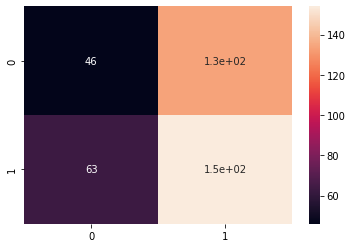

In [ ]:
sns.heatmap(confusion_matrix(real_closing, fake_closing), annot=True)